In [1]:
# lib
import talib
import pandas as pd
import yfinance as yf
import datetime as dt
import json
import csv
import requests

In [2]:
# global variable
GLOBAL_FILE_PATH = "E:\\amequant_data"

In [14]:
# 获取数据下载时间
# read time log
with open('dmypy.json', 'r') as f:
    jsdata = json.load(f)

now = dt.datetime.now()
next_date = dt.datetime.strptime(jsdata['end_date'], '%Y-%m-%d') + dt.timedelta(days=1)

if now >= next_date:
    start_date = next_date
    start_date = start_date.strftime('%Y-%m-%d')
    end_date = now.strftime('%Y-%m-%d')
    jsdata['end_date'] = end_date

# update time log
with open('dmypy.json', 'w') as f:
    json.dump(jsdata, f, indent=4)


In [19]:
# 获取股票数据
# path 1 从datahub.io中搜索数据（数据不全）
# all_tickers = pd.read_csv('https://datahub.io/core/s-and-p-500-companies/r/constituents.csv')
# all_tickers_symbols = all_tickers.Symbol.tolist()
# path 2 从www.alphavantage.co中拉取股票代码
# 设置API密钥和API地址
with open('dmypy.json', 'r') as f:
    jsdata = json.load(f)

api_key = jsdata['alpha_vantage_key']
api_url = f'https://www.alphavantage.co/query?function=LISTING_STATUS&apikey={api_key}'

# 发送请求并获取JSON数据
with requests.Session() as req:
    response = req.get(api_url)
    data = response.content.decode('utf-8')
    cr = csv.reader(data.splitlines(), delimiter=',')
    cr_list = list(cr)

df = pd.DataFrame(cr_list[1:], columns=cr_list[0])
    
# 提取股票代码并打印
tickers = list(df['symbol'])
print(len(tickers))


['A', 'AA', 'AAA', 'AAAU', 'AAC', 'AAC-U', 'AAC-WS', 'AACG', 'AACI', 'AACIU', 'AACIW', 'AADI', 'AADR', 'AAIC', 'AAIC-P-B', 'AAIC-P-C', 'AAIN', 'AAL', 'AAMC', 'AAME', 'AAN', 'AAOI', 'AAON', 'AAP', 'AAPB', 'AAPD', 'AAPL', 'AAPU', 'AAT', 'AAU', 'AAWW', 'AAXJ', 'AB', 'ABB', 'ABBV', 'ABC', 'ABCB', 'ABCL', 'ABCM', 'ABEO', 'ABEQ', 'ABEV', 'ABG', 'ABIO', 'ABM', 'ABNB', 'ABOS', 'ABR', 'ABR-P-D', 'ABR-P-E', 'ABR-P-F', 'ABSI', 'ABST', 'ABT', 'ABUS', 'ABVC', 'AC', 'ACA', 'ACAB', 'ACABU', 'ACABW', 'ACAC', 'ACACU', 'ACACW', 'ACAD', 'ACAH', 'ACAHU', 'ACAHW', 'ACAQ', 'ACAQ-U', 'ACAQ-WS', 'ACAX', 'ACAXR', 'ACAXU', 'ACAXW', 'ACB', 'ACBA', 'ACBAU', 'ACBAW', 'ACCD', 'ACCO', 'ACDC', 'ACDCW', 'ACEL', 'ACER', 'ACES', 'ACET', 'ACGL', 'ACGLN', 'ACGLO', 'ACGN', 'ACHC', 'ACHL', 'ACHR', 'ACHV', 'ACI', 'ACIO', 'ACIU', 'ACIW', 'ACLS', 'ACLX', 'ACM', 'ACMR', 'ACN', 'ACNB', 'ACNT', 'ACON', 'ACONW', 'ACOR', 'ACP', 'ACP-P-A', 'ACR', 'ACR-P-C', 'ACR-P-D', 'ACRE', 'ACRO', 'ACRO-U', 'ACRO-WS', 'ACRS', 'ACRV', 'ACRX', 'ACS

In [30]:
start_date = '2022-01-01'
end_date = '2022-01-15'
proxy = '127.0.0.1:21882'

tickers = ['BIDU']
data = yfd.download(tickers)


TypeError: Invalid download type.

In [24]:
aapl_his = aapl_his.reset_index()
aapl_his

,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,tic
0,0,2022-01-03 00:00:00-05:00,176.534316,181.547525,176.415195,180.683853,104487900,0.00,0.0,AAPL
1,1,2022-01-04 00:00:00-05:00,181.299377,181.607116,177.814941,178.390717,99310400,0.00,0.0,AAPL
2,2,2022-01-05 00:00:00-05:00,178.301354,178.857271,173.367564,173.645523,94537600,0.00,0.0,AAPL
3,3,2022-01-06 00:00:00-05:00,171.441708,174.022770,170.389433,170.746811,96904000,0.00,0.0,AAPL
4,4,2022-01-07 00:00:00-05:00,171.630328,172.871221,169.783880,170.915573,86709100,0.00,0.0,AAPL
5,5,2022-01-10 00:00:00-05:00,167.848084,171.243164,166.944710,170.935425,106765600,0.00,0.0,AAPL
6,6,2022-01-11 00:00:00-05:00,171.064482,173.903629,169.575411,173.804367,76138300,0.00,0.0,AAPL
7,7,2022-01-12 00:00:00-05:00,174.836766,175.889040,173.546250,174.251068,74805200,0.00,0.0,AAPL
8,8,2022-01-13 00:00:00-05:00,174.499264,175.333141,170.538330,170.935425,84505800,0.00,0.0,AAPL
9,9,2022-01-14 00:00:00-05:00,170.091630,172.513855,169.843451,171.809036,80440800,0.00,0.0,AAPL


In [35]:
symbol = ['AAPL']
start_date = '2020-01-01'
end_date = '2022-03-22'
df = yf.download(symbol, start='2022-01-01',end='2022-03-01', threads=True, proxy='127.0.0.1:21882')
df
# df = yf.download(symbol, start=start_date, end=end_date, threads=True)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


In [36]:
# show data
df.size

0

<Axes: xlabel='Date'>

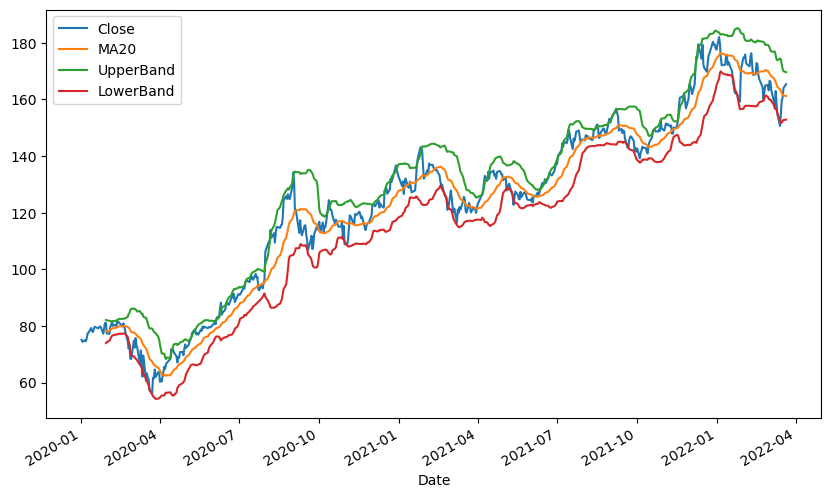

In [18]:
# 计算BOLL线
df['MA20'] = talib.SMA(df['Close'], timeperiod=20)
df['STD20'] = talib.STDDEV(df['Close'], timeperiod=20)
df['UpperBand'] = df['MA20'] + 2 * df['STD20']
df['LowerBand'] = df['MA20'] - 2 * df['STD20']

# 计算买卖信号
df['Signal'] = 0
df.loc[df['Close'] < df['LowerBand'], 'Signal'] = 1
df.loc[df['Close'] > df['UpperBand'], 'Signal'] = -1

# 计算持仓状态和收益
df['Position'] = df['Signal'].shift(1)
df['Position'].fillna(method='ffill', inplace=True)
df['Returns'] = df['Close'] * df['Position'].shift(1)

# 计算累计收益率和绘图
df['CumReturns'] = (df['Returns'].cumsum() + 1).fillna(1)
df[['Close', 'MA20', 'UpperBand', 'LowerBand']].plot(figsize=(10, 6))
# df['CumReturns'].plot(figsize=(10, 6), secondary_y=True)
